## Remapping 3D ERAI field on 1°x1° grid without land-sea masks using xESMF¶

Different algorithms are available:

Bilinear and conservative (need corners) should be the most commonly used methods. They are both monotonic (i.e. will not create new maximum/minimum).
Nearest neighbour methods, either source to destination (s2d) or destination to source (d2s), could be useful in special cases. Keep in mind that d2s is highly non-monotonic.
Patch is ESMF's unique method, producing highly smooth results but quite slow.

Detailed explanations are available on ESMPy documentation (https://xesmf.readthedocs.io/en/latest/why.html)

Choose kernel gloenv_py3.10

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from netCDF4 import Dataset
import numpy as np
import math
import xarray as xr
import xesmf as xe
import pandas as pd
import time as t

In [2]:
begin = t.time()

In [3]:
method_list = [
    "conservative",
    "bilinear",
    "nearest_s2d",
    "nearest_d2s",
    "patch",
]
method=method_list[4]
print("Remapping :"+method)

Remapping :patch


In [4]:
# Useful functions
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def get_lon_name(ds):
    for lon_name in ['lon', 'longitude']:
        if lon_name in ds.coords:
            return lon_name
    raise RuntimeError("Couldn't find a longitude coordinate")

In [5]:
var_ini_3D='ua'
file_ini=xr.open_mfdataset('/archive/globc/datamg/globc_obs/ERAI_no_more_MAJ/'+var_ini_3D+'_1d_3D/'+var_ini_3D+'*.nc')

In [6]:
niveau = 200
var_level = file_ini.sel(level=niveau)

In [7]:
dir_out='/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/'

In [8]:
var_target_grid = xr.open_dataset('/data/scratch/globc/dcom/CMIP6_TOOLS/xESMF_Interpolation/tavg_BEST_1deg.nc')

In [9]:
ds_in = xr.Dataset(
    {
        "lat": (["lat"], var_level[get_lat_name(var_level)].values),
        "lon": (["lon"], var_level[get_lon_name(var_level)].values),
    }
)
ds_in

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 240)
Coordinates:
  * lat      (lat) float32 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float32 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
Data variables:
    *empty*

In [10]:
# créer la grille pour le conservative (avec les bounds)
ds_in = xe.util.grid_2d(
    -0.75, 359.25, 1.5, 90.75, -90.75, -1.5  # longitude & latitude range and resolution
) 
ds_in

<xarray.Dataset>
Dimensions:  (y: 121, x: 240, y_b: 122, x_b: 241)
Coordinates:
    lon      (y, x) float64 0.0 1.5 3.0 4.5 6.0 ... 354.0 355.5 357.0 358.5
    lat      (y, x) float64 90.0 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0 -90.0
    lon_b    (y_b, x_b) float64 -0.75 0.75 2.25 3.75 ... 354.8 356.2 357.8 359.2
    lat_b    (y_b, x_b) float64 90.75 90.75 90.75 90.75 ... -90.75 -90.75 -90.75
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [11]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], var_target_grid[get_lat_name(var_target_grid)].values),
        "lon": (["lon"], var_target_grid[get_lon_name(var_target_grid)].values),
    }
)
ds_out

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    *empty*

In [12]:
# créer la grille pour le conservative (avec les bounds)
ds_out = xe.util.grid_2d(
    -180., 180, 1, -90, 90, 1  # longitude & latitude range and resolution
) 
ds_out

<xarray.Dataset>
Dimensions:  (y: 180, x: 360, y_b: 181, x_b: 361)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon_b    (y_b, x_b) float64 -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [13]:
regridder = xe.Regridder(ds_in, ds_out, method, periodic=True)
regridder  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       patch 
Weight filename:            patch_121x240_180x360_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (121, 240) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

In [14]:
var_level_interp = regridder(var_level)
var_level_interp

/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/xesmf/frontend.py:597: UserWarning: Using dimensions ('latitude', 'longitude') from data variable ua as the horizontal dimensions for the regridding.
  warnings.warn(


<xarray.Dataset>
Dimensions:  (time: 14610, y: 180, x: 360)
Coordinates:
    level    float64 200.0
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: y, x
Data variables:
    ua       (time, y, x) float32 dask.array<chunksize=(365, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  patch

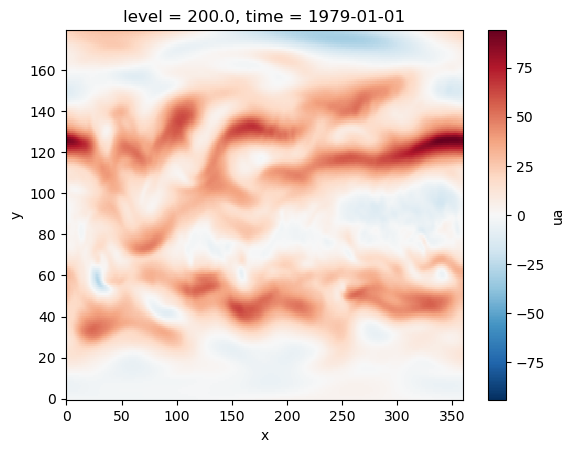

In [15]:
var_level_interp[var_ini_3D].isel(time=0).plot()

In [ ]:
var_level_interp.to_netcdf(path=dir_out+var_ini_3D+'_'+str(niveau)+'_'+str(method)+'_ERAI-1deg.nc', mode='w')

In [ ]:
end = t.time()
print('Runtime to calculate the weights is', '{0:.1f}'.format(end - begin), 's')